# U-Net for Supervised Image Denoising (30k Images)

This notebook trains a U-Net model for supervised image denoising, configured for a dataset of approximately 30,000 images.

**Features:**
- U-Net architecture suitable for image restoration.
- Handles large datasets by splitting into Training and Validation sets.
- Implements Validation loop to monitor generalization.
- Uses Learning Rate Scheduling (`ReduceLROnPlateau`) based on validation loss.
- Saves the best model checkpoint based on validation performance.
- Implements Early Stopping to prevent overfitting and save time.
- Includes a Testing section to load the best model and denoise a sample image.

## Imports

In [25]:
import os
import glob
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Use standard tqdm if not in notebook: from tqdm import tqdm
import time
import copy # For potentially saving best model state if needed differently

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split # For splitting data

## Configuration Parameters

In [26]:
# --- File Paths and Names ---
DATA_DIR = '/kaggle/input/aiml-project/train_images_500' # <<< !!! CHANGE THIS to the path of your 30k images !!!
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50'   # Directory containing test images (used in Section 3)
MODEL_SAVE_DIR = '/kaggle/working/'            # Directory to save the best model checkpoint

# --- Image Parameters ---
IMG_SIZE = 256 # Keep at 128 initially for 4GB VRAM, or decrease further if needed.
N_IMG_CHANNELS = 3 # Input/Output channels (3 for RGB)

# --- Training Parameters ---
VAL_SPLIT_RATIO = 0.15 # Fraction of data for validation (15% of 30k is 4.5k images)
BATCH_SIZE = 16     # <<< !!! START WITH 8 or 16 for 4GB VRAM! MONITOR MEMORY & ADJUST IF NEEDED! !!!
LEARNING_RATE = 1e-4
EPOCHS = 100        # Max number of epochs (Early Stopping will likely stop sooner)
NOISE_TYPE = 'gauss'# Noise type for training data: 'gauss' or 'poiss'
NOISE_LEVEL = 75    # Noise level for training (0-255 for Gauss, 0-1 scale for Poisson)

BEST_MODEL_NAME = 'n2n_nl'+f'{NOISE_LEVEL}'+'_best.pth' # Name for the best model checkpoint


# --- Early Stopping & LR Scheduler ---
EARLY_STOPPING_PATIENCE = 10 # Stop if validation loss doesn't improve for this many epochs
LR_SCHEDULER_PATIENCE = 5  # Reduce LR if validation loss doesn't improve for this many epochs
LR_SCHEDULER_FACTOR = 0.2  # Factor to reduce LR by (new_lr = lr * factor)

# --- U-Net Parameters ---
INIT_FEATURES = 64 # Number of features/channels in the first layer of U-Net
BILINEAR_UPSAMPLE = True # Use bilinear upsampling in U-Net

# --- System Parameters ---
NUM_WORKERS = 0 # Number of workers for DataLoader (adjust based on CPU cores)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Directory Setup ---
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(TEST_IMG_DIR, exist_ok=True)

# --- Reproducibility (Optional) ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


## Helper Functions (Preprocessing & Noise)

In [27]:
def preprocess_image(image_path, img_size):
    """Loads, resizes, normalizes, and converts image to PyTorch tensor."""
    try:
        img = Image.open(image_path).convert('RGB')
        img = TF.resize(img, [img_size, img_size], interpolation=TF.InterpolationMode.BILINEAR)
        img_tensor = TF.to_tensor(img)
        if img_tensor.shape[0] != N_IMG_CHANNELS:
             if N_IMG_CHANNELS == 1 and img_tensor.shape[0] == 3: img_tensor = TF.rgb_to_grayscale(img_tensor)
             elif N_IMG_CHANNELS == 3 and img_tensor.shape[0] == 1: img_tensor = TF.grayscale_to_rgb(img_tensor)
             else:
                 print(f"Warning: Channel mismatch for {image_path}. Skipping.")
                 return None
        return img_tensor
    except Exception as e:
        print(f"Error processing {image_path}: {e}. Skipping.")
        return None

def add_noise(x, noise_type='gauss', noise_level=25):
    """Adds Gaussian or Poisson noise to a clean image tensor (range [0, 1])."""
    if noise_type == 'gauss':
        std_dev = noise_level / 255.0
        noisy = x + torch.randn_like(x) * std_dev
    elif noise_type == 'poiss':
        noisy = torch.poisson(noise_level * x) / noise_level
    else: # Unknown noise type
        print(f"Warning: Unknown noise type '{noise_type}'. Returning original image.")
        noisy = x
    return torch.clamp(noisy, 0.0, 1.0)

## U-Net Model Definition

In [28]:
class DoubleConv(nn.Module):
    """(Convolution => [BatchNorm] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]; diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__(); self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, init_features=64, bilinear=True):
        super(UNet, self).__init__(); self.n_channels = n_channels; self.n_classes = n_classes; self.bilinear = bilinear
        factor = 2 if bilinear else 1
        self.inc = DoubleConv(n_channels, init_features)
        self.down1 = Down(init_features, init_features * 2); self.down2 = Down(init_features * 2, init_features * 4)
        self.down3 = Down(init_features * 4, init_features * 8); self.down4 = Down(init_features * 8, init_features * 16 // factor)
        self.up1 = Up(init_features * 16, init_features * 8 // factor, bilinear); self.up2 = Up(init_features * 8, init_features * 4 // factor, bilinear)
        self.up3 = Up(init_features * 4, init_features * 2 // factor, bilinear); self.up4 = Up(init_features * 2, init_features, bilinear)
        self.outc = OutConv(init_features, n_classes)
    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1); logits = self.outc(x)
        return logits

## Dataset Definition

In [29]:
class DenoisingImageDataset(Dataset):
    def __init__(self, image_paths, img_size, noise_type, noise_level, transform=None):
        self.image_paths = image_paths; self.img_size = img_size; self.noise_type = noise_type
        self.noise_level = noise_level; self.transform = transform
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            clean_img_tensor = preprocess_image(img_path, self.img_size)
            if clean_img_tensor is None:
                print(f"Warning: Skipping item {idx} due to preprocessing error, trying random next.")
                return self.__getitem__(random.randint(0, len(self) - 1))
            # Apply transformations if any (applied identically) - complex, omitted here
            noisy_input = add_noise(clean_img_tensor, self.noise_type, self.noise_level)
            noisy_target = add_noise(clean_img_tensor, self.noise_type, self.noise_level)
            return noisy_input, noisy_target
        except Exception as e:
            print(f"Error in __getitem__ for index {idx}, path {img_path}: {e}")
            return self.__getitem__(random.randint(0, len(self) - 1)) # Return random different item on error

## Section 1: Data Loading and Preparation

In [30]:
print("--- Phase 1: Data Loading and Preparation ---")
all_image_paths = glob.glob(os.path.join(DATA_DIR, '*.[jJ][pP][gG]')) \
                 + glob.glob(os.path.join(DATA_DIR, '*.[pP][nN][gG]')) \
                 + glob.glob(os.path.join(DATA_DIR, '*.[tT][iI][fF][fF]')) # Add more if needed

if not all_image_paths:
    print(f"Error: No images found in '{DATA_DIR}'. Please ensure the path is correct and contains images.")
    # Or raise an error: raise FileNotFoundError(f"No images found in {DATA_DIR}")
else:
    print(f"Found {len(all_image_paths)} total images in '{DATA_DIR}'.")

    # Split paths into training and validation sets
    train_paths, val_paths = train_test_split(all_image_paths, test_size=VAL_SPLIT_RATIO, random_state=42)
    print(f"Using {len(train_paths)} images for training, {len(val_paths)} for validation.")

    # Create Datasets
    train_dataset = DenoisingImageDataset(train_paths, IMG_SIZE, NOISE_TYPE, NOISE_LEVEL)
    val_dataset = DenoisingImageDataset(val_paths, IMG_SIZE, NOISE_TYPE, NOISE_LEVEL)

    # Create DataLoaders
    pin_mem = True if device == torch.device("cuda") else False
    # persistent_workers=True can speed up epoch start after the first one if num_workers > 0
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                  num_workers=NUM_WORKERS, pin_memory=pin_mem, persistent_workers=(NUM_WORKERS > 0))
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                num_workers=NUM_WORKERS, pin_memory=pin_mem, persistent_workers=(NUM_WORKERS > 0))

    print("DataLoaders created.")


--- Phase 1: Data Loading and Preparation ---
Found 500 total images in '/kaggle/input/aiml-project/train_images_500'.
Using 425 images for training, 75 for validation.
DataLoaders created.


## Section 2: Model Training

In [31]:
# --- Initialize Model, Loss, Optimizer, Scheduler ---
print("\n--- Phase 2: Model Training ---")
# Ensure DataLoaders were created before proceeding
if 'train_dataloader' not in locals() or 'val_dataloader' not in locals():
     print("DataLoaders not available. Please ensure Section 1 ran successfully and found images.")
else:
    model = UNet(n_channels=N_IMG_CHANNELS, n_classes=N_IMG_CHANNELS, init_features=INIT_FEATURES, bilinear=BILINEAR_UPSAMPLE).to(device)
    print(f"U-Net Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)

    # --- Variables for tracking best model and early stopping ---
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)
    train_losses, val_losses = [], [] # Store losses for plotting


--- Phase 2: Model Training ---
U-Net Model Parameters: 17,263,107


Starting training loop...


Epoch 1/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.235382, Val Loss: 0.215763
Val loss improved (inf --> 0.215763). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 2/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/100 - Train Loss: 0.082456, Val Loss: 0.075260
Val loss improved (0.215763 --> 0.075260). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 3/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/100 - Train Loss: 0.069877, Val Loss: 0.068165
Val loss improved (0.075260 --> 0.068165). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 4/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/100 - Train Loss: 0.066087, Val Loss: 0.070140
Val loss did not improve for 1 epoch(s).


Epoch 5/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/100 - Train Loss: 0.064493, Val Loss: 0.064808
Val loss improved (0.068165 --> 0.064808). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 6/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6/100 - Train Loss: 0.064025, Val Loss: 0.064094
Val loss improved (0.064808 --> 0.064094). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 7/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7/100 - Train Loss: 0.063367, Val Loss: 0.063834
Val loss improved (0.064094 --> 0.063834). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 8/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8/100 - Train Loss: 0.063618, Val Loss: 0.063524
Val loss improved (0.063834 --> 0.063524). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 9/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9/100 - Train Loss: 0.063100, Val Loss: 0.063511
Val loss improved (0.063524 --> 0.063511). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 10/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10/100 - Train Loss: 0.062957, Val Loss: 0.064088
Val loss did not improve for 1 epoch(s).


Epoch 11/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11/100 - Train Loss: 0.062747, Val Loss: 0.063725
Val loss did not improve for 2 epoch(s).


Epoch 12/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12/100 - Train Loss: 0.063043, Val Loss: 0.063101
Val loss improved (0.063511 --> 0.063101). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 13/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13/100 - Train Loss: 0.063237, Val Loss: 0.063584
Val loss did not improve for 1 epoch(s).


Epoch 14/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14/100 - Train Loss: 0.062430, Val Loss: 0.064188
Val loss did not improve for 2 epoch(s).


Epoch 15/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15/100 - Train Loss: 0.062984, Val Loss: 0.063359
Val loss did not improve for 3 epoch(s).


Epoch 16/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16/100 - Train Loss: 0.062698, Val Loss: 0.062789
Val loss improved (0.063101 --> 0.062789). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 17/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17/100 - Train Loss: 0.062383, Val Loss: 0.062616
Val loss improved (0.062789 --> 0.062616). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 18/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18/100 - Train Loss: 0.062542, Val Loss: 0.063270
Val loss did not improve for 1 epoch(s).


Epoch 19/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19/100 - Train Loss: 0.062124, Val Loss: 0.062723
Val loss did not improve for 2 epoch(s).


Epoch 20/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20/100 - Train Loss: 0.062505, Val Loss: 0.062815
Val loss did not improve for 3 epoch(s).


Epoch 21/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21/100 - Train Loss: 0.062306, Val Loss: 0.062488
Val loss improved (0.062616 --> 0.062488). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 22/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22/100 - Train Loss: 0.062090, Val Loss: 0.062453
Val loss improved (0.062488 --> 0.062453). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 23/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 23/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23/100 - Train Loss: 0.062040, Val Loss: 0.063480
Val loss did not improve for 1 epoch(s).


Epoch 24/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 24/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24/100 - Train Loss: 0.062249, Val Loss: 0.062600
Val loss did not improve for 2 epoch(s).


Epoch 25/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 25/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25/100 - Train Loss: 0.061907, Val Loss: 0.062332
Val loss improved (0.062453 --> 0.062332). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 26/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 26/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26/100 - Train Loss: 0.062156, Val Loss: 0.062769
Val loss did not improve for 1 epoch(s).


Epoch 27/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 27/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27/100 - Train Loss: 0.061984, Val Loss: 0.062474
Val loss did not improve for 2 epoch(s).


Epoch 28/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 28/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28/100 - Train Loss: 0.061730, Val Loss: 0.062169
Val loss improved (0.062332 --> 0.062169). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 29/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 29/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29/100 - Train Loss: 0.061611, Val Loss: 0.062486
Val loss did not improve for 1 epoch(s).


Epoch 30/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 30/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30/100 - Train Loss: 0.062089, Val Loss: 0.062906
Val loss did not improve for 2 epoch(s).


Epoch 31/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 31/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31/100 - Train Loss: 0.061529, Val Loss: 0.062137
Val loss improved (0.062169 --> 0.062137). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 32/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 32/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32/100 - Train Loss: 0.062158, Val Loss: 0.062097
Val loss improved (0.062137 --> 0.062097). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 33/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 33/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33/100 - Train Loss: 0.061855, Val Loss: 0.063296
Val loss did not improve for 1 epoch(s).


Epoch 34/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 34/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34/100 - Train Loss: 0.061894, Val Loss: 0.062174
Val loss did not improve for 2 epoch(s).


Epoch 35/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 35/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35/100 - Train Loss: 0.061706, Val Loss: 0.062366
Val loss did not improve for 3 epoch(s).


Epoch 36/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 36/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36/100 - Train Loss: 0.061511, Val Loss: 0.062095
Val loss improved (0.062097 --> 0.062095). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 37/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 37/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37/100 - Train Loss: 0.061473, Val Loss: 0.062340
Val loss did not improve for 1 epoch(s).


Epoch 38/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 38/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38/100 - Train Loss: 0.061535, Val Loss: 0.061965
Val loss improved (0.062095 --> 0.061965). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 39/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 39/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39/100 - Train Loss: 0.061472, Val Loss: 0.062256
Val loss did not improve for 1 epoch(s).


Epoch 40/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 40/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40/100 - Train Loss: 0.061667, Val Loss: 0.062101
Val loss did not improve for 2 epoch(s).


Epoch 41/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 41/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41/100 - Train Loss: 0.061319, Val Loss: 0.062195
Val loss did not improve for 3 epoch(s).


Epoch 42/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 42/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42/100 - Train Loss: 0.061249, Val Loss: 0.065484
Val loss did not improve for 4 epoch(s).


Epoch 43/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 43/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43/100 - Train Loss: 0.061481, Val Loss: 0.062069
Val loss did not improve for 5 epoch(s).


Epoch 44/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 44/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44/100 - Train Loss: 0.061149, Val Loss: 0.062130
Val loss did not improve for 6 epoch(s).


Epoch 45/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 45/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45/100 - Train Loss: 0.061291, Val Loss: 0.061887
Val loss improved (0.061965 --> 0.061887). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 46/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 46/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46/100 - Train Loss: 0.060980, Val Loss: 0.061830
Val loss improved (0.061887 --> 0.061830). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 47/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 47/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47/100 - Train Loss: 0.061096, Val Loss: 0.061860
Val loss did not improve for 1 epoch(s).


Epoch 48/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 48/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48/100 - Train Loss: 0.060979, Val Loss: 0.061770
Val loss improved (0.061830 --> 0.061770). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 49/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 49/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49/100 - Train Loss: 0.060923, Val Loss: 0.061804
Val loss did not improve for 1 epoch(s).


Epoch 50/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 50/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50/100 - Train Loss: 0.061114, Val Loss: 0.061834
Val loss did not improve for 2 epoch(s).


Epoch 51/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 51/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51/100 - Train Loss: 0.060903, Val Loss: 0.061789
Val loss did not improve for 3 epoch(s).


Epoch 52/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 52/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52/100 - Train Loss: 0.060865, Val Loss: 0.061758
Val loss improved (0.061770 --> 0.061758). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 53/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 53/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53/100 - Train Loss: 0.061042, Val Loss: 0.061758
Val loss did not improve for 1 epoch(s).


Epoch 54/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 54/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54/100 - Train Loss: 0.060959, Val Loss: 0.061804
Val loss did not improve for 2 epoch(s).


Epoch 55/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 55/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55/100 - Train Loss: 0.060917, Val Loss: 0.061806
Val loss did not improve for 3 epoch(s).


Epoch 56/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 56/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56/100 - Train Loss: 0.060814, Val Loss: 0.061774
Val loss did not improve for 4 epoch(s).


Epoch 57/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 57/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57/100 - Train Loss: 0.060732, Val Loss: 0.061805
Val loss did not improve for 5 epoch(s).


Epoch 58/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 58/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58/100 - Train Loss: 0.060888, Val Loss: 0.061742
Val loss improved (0.061758 --> 0.061742). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 59/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 59/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59/100 - Train Loss: 0.060857, Val Loss: 0.061759
Val loss did not improve for 1 epoch(s).


Epoch 60/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 60/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60/100 - Train Loss: 0.060905, Val Loss: 0.061751
Val loss did not improve for 2 epoch(s).


Epoch 61/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 61/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61/100 - Train Loss: 0.060952, Val Loss: 0.061772
Val loss did not improve for 3 epoch(s).


Epoch 62/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 62/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62/100 - Train Loss: 0.060930, Val Loss: 0.061725
Val loss improved (0.061742 --> 0.061725). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 63/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 63/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63/100 - Train Loss: 0.060840, Val Loss: 0.061730
Val loss did not improve for 1 epoch(s).


Epoch 64/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 64/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64/100 - Train Loss: 0.060947, Val Loss: 0.061746
Val loss did not improve for 2 epoch(s).


Epoch 65/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 65/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65/100 - Train Loss: 0.060892, Val Loss: 0.061739
Val loss did not improve for 3 epoch(s).


Epoch 66/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 66/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66/100 - Train Loss: 0.060877, Val Loss: 0.061725
Val loss did not improve for 4 epoch(s).


Epoch 67/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 67/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67/100 - Train Loss: 0.060910, Val Loss: 0.061807
Val loss did not improve for 5 epoch(s).


Epoch 68/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 68/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68/100 - Train Loss: 0.060783, Val Loss: 0.061699
Val loss improved (0.061725 --> 0.061699). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 69/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 69/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69/100 - Train Loss: 0.061068, Val Loss: 0.062193
Val loss did not improve for 1 epoch(s).


Epoch 70/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 70/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70/100 - Train Loss: 0.060952, Val Loss: 0.061787
Val loss did not improve for 2 epoch(s).


Epoch 71/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 71/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71/100 - Train Loss: 0.060806, Val Loss: 0.061687
Val loss improved (0.061699 --> 0.061687). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 72/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 72/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72/100 - Train Loss: 0.060890, Val Loss: 0.061759
Val loss did not improve for 1 epoch(s).


Epoch 73/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 73/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73/100 - Train Loss: 0.060835, Val Loss: 0.061687
Val loss did not improve for 2 epoch(s).


Epoch 74/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 74/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74/100 - Train Loss: 0.060772, Val Loss: 0.061693
Val loss did not improve for 3 epoch(s).


Epoch 75/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 75/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75/100 - Train Loss: 0.060917, Val Loss: 0.061701
Val loss did not improve for 4 epoch(s).


Epoch 76/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 76/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76/100 - Train Loss: 0.060940, Val Loss: 0.061691
Val loss did not improve for 5 epoch(s).


Epoch 77/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 77/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77/100 - Train Loss: 0.060813, Val Loss: 0.061691
Val loss did not improve for 6 epoch(s).


Epoch 78/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 78/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78/100 - Train Loss: 0.060754, Val Loss: 0.061694
Val loss did not improve for 7 epoch(s).


Epoch 79/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 79/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79/100 - Train Loss: 0.060784, Val Loss: 0.061684
Val loss improved (0.061687 --> 0.061684). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 80/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 80/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80/100 - Train Loss: 0.060723, Val Loss: 0.061695
Val loss did not improve for 1 epoch(s).


Epoch 81/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 81/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81/100 - Train Loss: 0.060863, Val Loss: 0.061684
Val loss improved (0.061684 --> 0.061684). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 82/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 82/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82/100 - Train Loss: 0.060715, Val Loss: 0.061666
Val loss improved (0.061684 --> 0.061666). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 83/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 83/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83/100 - Train Loss: 0.060763, Val Loss: 0.061680
Val loss did not improve for 1 epoch(s).


Epoch 84/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 84/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84/100 - Train Loss: 0.060713, Val Loss: 0.061685
Val loss did not improve for 2 epoch(s).


Epoch 85/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 85/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85/100 - Train Loss: 0.060861, Val Loss: 0.061680
Val loss did not improve for 3 epoch(s).


Epoch 86/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 86/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86/100 - Train Loss: 0.060713, Val Loss: 0.061649
Val loss improved (0.061666 --> 0.061649). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 87/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 87/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87/100 - Train Loss: 0.060716, Val Loss: 0.061674
Val loss did not improve for 1 epoch(s).


Epoch 88/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 88/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88/100 - Train Loss: 0.060794, Val Loss: 0.061676
Val loss did not improve for 2 epoch(s).


Epoch 89/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 89/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89/100 - Train Loss: 0.060831, Val Loss: 0.061670
Val loss did not improve for 3 epoch(s).


Epoch 90/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 90/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90/100 - Train Loss: 0.060772, Val Loss: 0.061689
Val loss did not improve for 4 epoch(s).


Epoch 91/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 91/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91/100 - Train Loss: 0.060678, Val Loss: 0.061644
Val loss improved (0.061649 --> 0.061644). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 92/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 92/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92/100 - Train Loss: 0.060734, Val Loss: 0.061659
Val loss did not improve for 1 epoch(s).


Epoch 93/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 93/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93/100 - Train Loss: 0.060670, Val Loss: 0.061641
Val loss improved (0.061644 --> 0.061641). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 94/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 94/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94/100 - Train Loss: 0.060817, Val Loss: 0.061631
Val loss improved (0.061641 --> 0.061631). Saving model to /kaggle/working/n2n_nl75_best.pth


Epoch 95/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 95/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95/100 - Train Loss: 0.060775, Val Loss: 0.061651
Val loss did not improve for 1 epoch(s).


Epoch 96/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 96/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96/100 - Train Loss: 0.060753, Val Loss: 0.061680
Val loss did not improve for 2 epoch(s).


Epoch 97/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 97/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97/100 - Train Loss: 0.060786, Val Loss: 0.061671
Val loss did not improve for 3 epoch(s).


Epoch 98/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 98/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98/100 - Train Loss: 0.060750, Val Loss: 0.061648
Val loss did not improve for 4 epoch(s).


Epoch 99/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 99/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99/100 - Train Loss: 0.060790, Val Loss: 0.061725
Val loss did not improve for 5 epoch(s).


Epoch 100/100 [Train]:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch 100/100 [Val]:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100/100 - Train Loss: 0.060690, Val Loss: 0.061665
Val loss did not improve for 6 epoch(s).
Training Finished. Total time: 20.74 minutes
Best Validation Loss achieved: 0.061631


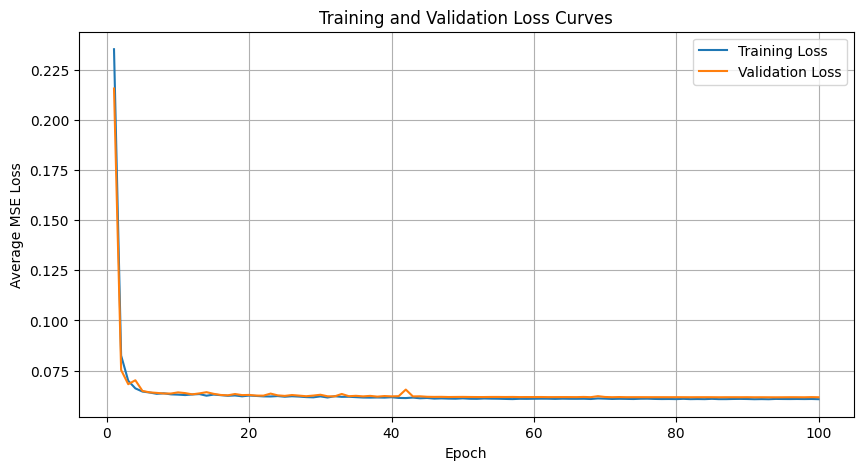

In [32]:
# --- Training Loop ---
print("Starting training loop...")
start_time = time.time()

for epoch in range(EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    train_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]", leave=False)
    for noisy_batch, clean_batch in train_progress_bar:
        noisy_batch = noisy_batch.to(device); clean_batch = clean_batch.to(device)
        optimizer.zero_grad(); predicted_clean_batch = model(noisy_batch)
        loss = criterion(predicted_clean_batch, clean_batch)
        loss.backward(); optimizer.step()
        running_train_loss += loss.item() * noisy_batch.size(0)
        train_progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    avg_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval(); running_val_loss = 0.0
    val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for noisy_batch, clean_batch in val_progress_bar:
            noisy_batch = noisy_batch.to(device); clean_batch = clean_batch.to(device)
            predicted_clean_batch = model(noisy_batch)
            loss = criterion(predicted_clean_batch, clean_batch)
            running_val_loss += loss.item() * noisy_batch.size(0)
            val_progress_bar.set_postfix(loss=f"{loss.item():.6f}")
    avg_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    # --- LR Scheduling, Checkpointing, Early Stopping ---
    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        print(f"Val loss improved ({best_val_loss:.6f} --> {avg_val_loss:.6f}). Saving model to {best_model_path}")
        best_val_loss = avg_val_loss
        try: torch.save(model.state_dict(), best_model_path)
        except Exception as e: print(f"Error saving model: {e}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1; print(f"Val loss did not improve for {epochs_no_improve} epoch(s).")
    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# --- Training Finished ---
end_time = time.time()
print(f"Training Finished. Total time: {(end_time - start_time)/60:.2f} minutes")
print(f"Best Validation Loss achieved: {best_val_loss:.6f}")

# --- Plot Loss Curves ---
plt.figure(figsize=(10, 5)); plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss'); plt.xlabel('Epoch'); plt.ylabel('Average MSE Loss')
plt.title('Training and Validation Loss Curves'); plt.legend(); plt.grid(True); plt.show()

## Section 3: Testing


In [33]:
# --- Parameters for Testing ---
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME) # Uses the best model saved
TEST_IMAGE_PATH = '/kaggle/input/aiml-project/491.jpg' # <<< CHANGE to your test image name
TEST_IMAGE_IS_ALREADY_NOISY = False # <<< SET according to your test image
TEST_NOISE_TYPE = 'gauss'           # Use same noise type as training ideally
TEST_NOISE_LEVEL = NOISE_LEVEL               # Use same noise level as training ideally
DENOISE_N_TIMES = 1              # Number of times to denoise the image (1 or more)


In [34]:
# --- Load Best Model ---
print("\n--- Phase 3: Testing ---")
print(f"Loading best model from: {SAVED_MODEL_PATH}")
testing_model_loaded = False
try:
    test_model = UNet(n_channels=N_IMG_CHANNELS, n_classes=N_IMG_CHANNELS, init_features=INIT_FEATURES, bilinear=BILINEAR_UPSAMPLE).to(device)
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() # Set model to evaluation mode
    print("Best model loaded successfully.")
    testing_model_loaded = True
except FileNotFoundError:
    print(f"Error: Best model file not found at {SAVED_MODEL_PATH}. Cannot perform testing.")
except Exception as e:
    print(f"Error loading model state_dict: {e}. Cannot perform testing.")


--- Phase 3: Testing ---
Loading best model from: /kaggle/working/n2n_nl75_best.pth
Best model loaded successfully.


/tmp/ipykernel_31/655531011.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


Loading test image: /kaggle/input/aiml-project/491.jpg
Adding gauss noise (level 75) to the test image.
Denoising (1 pass(es))...
Denoising complete.
PSNR (Noisy vs Clean): 11.93 dB
PSNR (Final Denoised vs Clean): 20.15 dB


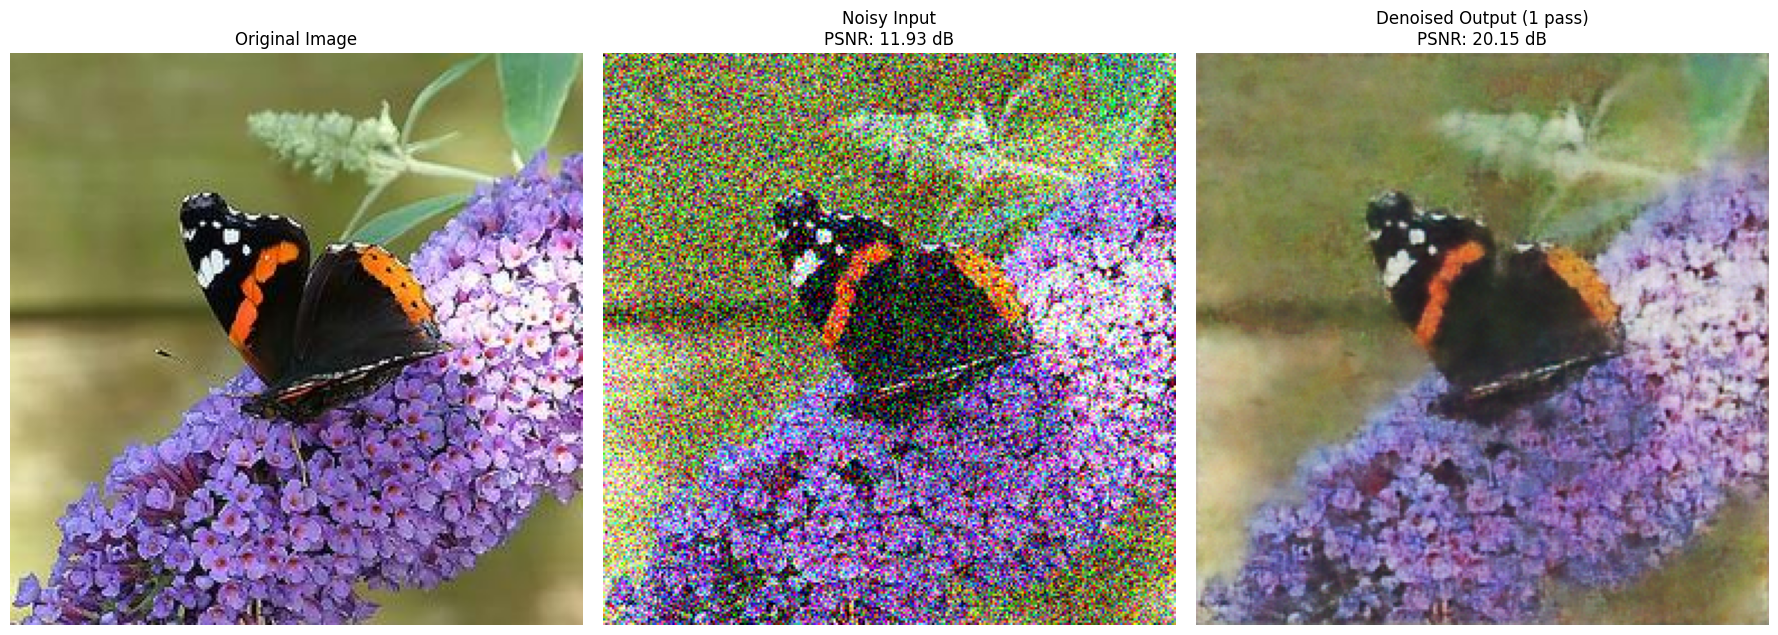

In [35]:
# NOTEBOOK CELL 3 (Updated with PSNR in plot titles)

# --- Load, Prepare, and Denoise Test Image ---
if testing_model_loaded:
    print(f"Loading test image: {TEST_IMAGE_PATH}")
    if not os.path.exists(TEST_IMAGE_PATH):
          print(f"Error: Test image not found at {TEST_IMAGE_PATH}")
          # Handle error or create dummy as before
          # For this example, assume we stop if not found, or handle appropriately
          input_tensor = None
    else:
        # Assume preprocess_image returns a CPU tensor [0,1] float CHW
        input_tensor_cpu = preprocess_image(TEST_IMAGE_PATH, IMG_SIZE)
        if input_tensor_cpu is None:
            input_tensor = None
            print("Error: Failed to preprocess test image.")
        else:
            input_tensor = input_tensor_cpu.to(device) # Move clean tensor to device

    if input_tensor is not None:
        # Keep a CPU copy of the original clean tensor for display later
        original_for_display = input_tensor.cpu().clone()

        # --- Prepare Noisy Input ---
        if not TEST_IMAGE_IS_ALREADY_NOISY:
            print(f"Adding {TEST_NOISE_TYPE} noise (level {TEST_NOISE_LEVEL}) to the test image.")
            # Assume add_noise returns tensor on the same device as input
            noisy_input_tensor = add_noise(input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)
        else:
            print("Test image is assumed to be already noisy.")
            noisy_input_tensor = input_tensor # Use the loaded tensor directly

        noisy_input_batch = noisy_input_tensor.unsqueeze(0) # Add batch dimension B=1

        # --- Perform Denoising (Potentially Multiple Passes) ---
        print(f"Denoising ({DENOISE_N_TIMES} pass(es))...")
        current_denoised_tensor = noisy_input_tensor # Start with noisy input for the first pass if DENOISE_N_TIMES > 0
        try:
            with torch.no_grad():
                # Initial pass
                current_denoised_batch = test_model(current_denoised_tensor.unsqueeze(0))
                current_denoised_tensor = torch.clamp(current_denoised_batch.squeeze(0), 0.0, 1.0)

                # Subsequent passes if DENOISE_N_TIMES > 1
                for i in range(DENOISE_N_TIMES - 1):
                    # print(f"  Denoising pass {i+2}/{DENOISE_N_TIMES}...") # Optional verbose output
                    current_denoised_batch = test_model(current_denoised_tensor.unsqueeze(0))
                    current_denoised_tensor = torch.clamp(current_denoised_batch.squeeze(0), 0.0, 1.0)

            # Final denoised tensor is stored in current_denoised_tensor
            denoised_output_tensor = current_denoised_tensor # Assign final result
            print("Denoising complete.")

        except Exception as e:
            print(f"An error occurred during denoising: {e}")
            denoised_output_tensor = None # Ensure it's None if denoising failed

        # --- Calculate PSNR and Display Results ---
        if denoised_output_tensor is not None:
            # --- Calculate PSNR Values ---
            # Ensure comparison tensors are on the correct device
            clean_tensor_device = original_for_display.to(device) # Move original clean CPU tensor to device
            # noisy_input_tensor and denoised_output_tensor are already on device

            # PSNR for Noisy vs Clean
            mse_noisy = F.mse_loss(noisy_input_tensor, clean_tensor_device)
            if mse_noisy.item() > 1e-10:
                psnr_noisy = 10 * torch.log10(1.0 / mse_noisy).item()
            else:
                psnr_noisy = float('inf')

            # PSNR for Final Denoised vs Clean
            mse_denoised = F.mse_loss(denoised_output_tensor, clean_tensor_device)
            if mse_denoised.item() > 1e-10:
                psnr_denoised = 10 * torch.log10(1.0 / mse_denoised).item()
            else:
                psnr_denoised = float('inf')

            print(f"PSNR (Noisy vs Clean): {psnr_noisy:.2f} dB")
            print(f"PSNR (Final Denoised vs Clean): {psnr_denoised:.2f} dB")

            # --- Prepare Tensors for Display (move to CPU, permute) ---
            noisy_display = noisy_input_tensor.cpu().permute(1, 2, 0).numpy()
            denoised_display = denoised_output_tensor.cpu().permute(1, 2, 0).numpy()
            original_display = original_for_display.permute(1, 2, 0).numpy() # Already on CPU

            # --- Plotting ---
            fig, ax = plt.subplots(1, 3, figsize=(18, 7)) # Adjusted size slightly

            ax[0].imshow(np.clip(original_display, 0, 1))
            ax[0].set_title('Original Image')
            ax[0].axis('off')

            ax[1].imshow(np.clip(noisy_display, 0, 1))
            # Updated title with PSNR
            ax[1].set_title(f'Noisy Input\nPSNR: {psnr_noisy:.2f} dB')
            ax[1].axis('off')

            ax[2].imshow(np.clip(denoised_display, 0, 1))
            # Updated title with PSNR and pass count
            denoised_title = f'Denoised Output ({DENOISE_N_TIMES} pass'
            denoised_title += 'es)' if DENOISE_N_TIMES > 1 else ')'
            denoised_title += f'\nPSNR: {psnr_denoised:.2f} dB'
            ax[2].set_title(denoised_title)
            ax[2].axis('off')

            plt.tight_layout(pad=1.5)
            plt.show()

        else:
            print("Skipping result display as denoising did not complete successfully.")
    else:
        print("Skipping testing phase as test image could not be loaded/processed.")
else:
    print("Skipping testing phase as model could not be loaded.")

In [36]:
# -*- coding: utf-8 -*-
import os
import time
import pandas as pd # For saving results to CSV
import numpy as np # For calculating average PSNR

import torch
import torch.nn as nn # Assuming UNet uses this
import torch.nn.functional as F # For mse_loss

# NOTE: Ensure necessary libraries like os, torch, pandas, numpy are imported.
# Assume the following are defined earlier in your script:
# - device = 'cuda' or 'cpu'
# - UNet class definition (or the correct model class)
# - preprocess_image(image_path, img_size) function
# - add_noise(image_tensor, noise_type, noise_level, device) function
# - IMG_SIZE (e.g., 256)
# - N_IMG_CHANNELS (e.g., 3)
# - INIT_FEATURES (parameter for UNet)
# - BILINEAR_UPSAMPLE (parameter for UNet)
# - MODEL_SAVE_DIR (e.g., './models')
# - BEST_MODEL_NAME (e.g., 'best_model_epoch_X.pth')

# --- Configuration for Batch Testing ---
TEST_IMG_DIR = '/kaggle/input/aiml-project/test_images_50' # Directory containing the 50 test images
CSV_OUTPUT_FILENAME = 'n2n_nl'+f'{NOISE_LEVEL}'+'_psnr.csv' # Output CSV filename for this test

# --- Iterative Denoising Parameter ---
# How many times to apply the denoising model sequentially
DENOISE_N_TIMES = 1  # As specified in the original Cell 1 for single image

# --- Noise Parameters for Testing ---
# Noise to ADD to the CLEAN test images. Should ideally match training conditions.
TEST_NOISE_TYPE = 'gauss' # Example: match training
TEST_NOISE_LEVEL = NOISE_LEVEL     # Example: match training (high noise level specified)

# --- Construct Model Path (using assumed variables) ---
# Ensure BEST_MODEL_NAME is defined appropriately earlier
SAVED_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, BEST_MODEL_NAME)

# --- Load Best Model (Once) ---
print("\n--- Preparing for Batch Testing ---")
print(f"Loading best model from: {SAVED_MODEL_PATH}")
testing_model_loaded = False
try:
    # Instantiate the model architecture (ensure parameters are correct)
    test_model = UNet(
        n_channels=N_IMG_CHANNELS,
        n_classes=N_IMG_CHANNELS, # Output channels usually same as input for denoising
        init_features=INIT_FEATURES,
        bilinear=BILINEAR_UPSAMPLE
    ).to(device)
    # Load the trained weights
    test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))
    test_model.eval() # Set model to evaluation mode (crucial!)
    print("Best model loaded successfully.")
    testing_model_loaded = True
except FileNotFoundError:
    print(f"Error: Best model file not found at {SAVED_MODEL_PATH}. Cannot perform testing.")
    # Decide how to handle: exit, raise, etc.
    raise FileNotFoundError(f"Model file not found at {SAVED_MODEL_PATH}")
except Exception as e:
    print(f"Error loading model state_dict: {e}. Cannot perform testing.")
    raise e # Re-raise

# --- Prepare for Batch Processing ---
if not testing_model_loaded:
    print("Exiting script as model could not be loaded.")
    exit() # Or handle differently

if not os.path.isdir(TEST_IMG_DIR):
    print(f"Error: Test image directory not found: {TEST_IMG_DIR}")
    raise FileNotFoundError(f"Test image directory not found: {TEST_IMG_DIR}")

# Get list of image files
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
try:
    all_files = os.listdir(TEST_IMG_DIR)
    image_files = sorted([f for f in all_files if f.lower().endswith(image_extensions)])
except Exception as e:
    print(f"Error listing files in {TEST_IMG_DIR}: {e}")
    raise

if not image_files:
    print(f"No image files with extensions {image_extensions} found in {TEST_IMG_DIR}")
    exit()

print(f"Found {len(image_files)} images to process in {TEST_IMG_DIR}.")

# --- Initialize Results Storage ---
results_data = [] # List to hold {'filename': ..., 'psnr_db': ...} dictionaries

# --- Process Each Image in the Directory ---
print(f"\nStarting batch denoising ({DENOISE_N_TIMES} passes per image) and PSNR calculation...")
start_time = time.time() # Optional: time the process

for filename in image_files:
    current_image_path = os.path.join(TEST_IMG_DIR, filename)
    print(f"Processing: {filename}...")

    try:
        # --- Load and Prepare Clean Test Image ---
        # Assumes preprocess_image loads, resizes to IMG_SIZE, returns [0,1] float CHW tensor (on CPU)
        clean_input_tensor_cpu = preprocess_image(current_image_path, IMG_SIZE)
        if clean_input_tensor_cpu is None:
            print(f"  Skipping {filename} due to preprocessing error.")
            results_data.append({'filename': filename, 'psnr_db': np.nan}) # Record error
            continue # Skip to next image

        clean_input_tensor = clean_input_tensor_cpu.to(device) # Move clean tensor to device

        # --- Add Noise ---
        # Assuming all images in the test dir are clean, add noise specified by TEST_NOISE_* vars
        # Assumes add_noise returns tensor on the specified device
        noisy_input_tensor = add_noise(clean_input_tensor, TEST_NOISE_TYPE, TEST_NOISE_LEVEL)

        # --- Perform Iterative Denoising ---
        current_tensor = noisy_input_tensor # Start with the noisy image for the first pass
        with torch.no_grad(): # Ensure no gradients are computed
            for pass_num in range(DENOISE_N_TIMES):
                # Add batch dimension, process, remove batch dimension, clamp
                input_batch = current_tensor.unsqueeze(0)
                output_batch = test_model(input_batch)
                current_tensor = torch.clamp(output_batch.squeeze(0), 0.0, 1.0)
                # print(f"    Pass {pass_num+1}/{DENOISE_N_TIMES} complete.") # Optional verbose

        # The final denoised result after all passes
        denoised_output_tensor = current_tensor

        # --- Calculate PSNR (Final Denoised vs Original Clean) ---
        # Both tensors should be on the 'device' already
        mse_loss = F.mse_loss(denoised_output_tensor, clean_input_tensor)

        # Calculate PSNR, handle potential zero MSE case
        if mse_loss.item() > 1e-10:
            psnr = 10 * torch.log10(1.0 / mse_loss) # Max signal value is 1.0
            current_psnr = psnr.item()
        else:
            current_psnr = float('inf') # Assign infinity for perfect reconstruction

        print(f"  Final PSNR after {DENOISE_N_TIMES} passes: {current_psnr:.2f} dB")

        # --- Store Result ---
        results_data.append({'filename': filename, 'psnr_db': current_psnr})

    except Exception as e:
        print(f"  Error processing {filename}: {e}")
        # Store NaN or another indicator for the error case
        results_data.append({'filename': filename, 'psnr_db': np.nan})
        # import traceback # Optional: for debugging
        # traceback.print_exc() # Optional: prints traceback

# --- End of Loop ---
end_time = time.time() # Optional
print(f"\nBatch processing completed in {end_time - start_time:.2f} seconds.")

# --- Calculate Average PSNR and Save Results ---
if results_data:
    # Convert results list to a pandas DataFrame
    results_df = pd.DataFrame(results_data)

    # Calculate average PSNR
    # Exclude NaN (errors) and Inf (perfect reconstruction) values for a meaningful average
    valid_psnr_values = results_df['psnr_db'].replace([np.inf, -np.inf], np.nan).dropna()

    if not valid_psnr_values.empty:
        average_psnr = valid_psnr_values.mean()
        print(f"\nAverage PSNR over {len(valid_psnr_values)} successfully processed images: {average_psnr:.2f} dB")
    else:
        average_psnr = np.nan # Indicate no valid results if all failed or were Inf
        print("\nCould not calculate average PSNR (no valid results).")

    # Save the full results DataFrame to CSV
    try:
        results_df.to_csv(CSV_OUTPUT_FILENAME, index=False)
        print(f"Results saved to {CSV_OUTPUT_FILENAME}")
    except Exception as e:
        print(f"Error saving results to CSV ({CSV_OUTPUT_FILENAME}): {e}")
else:
    print("No images were processed.")

print("\nScript finished.")


--- Preparing for Batch Testing ---
Loading best model from: /kaggle/working/n2n_nl75_best.pth


/tmp/ipykernel_31/3111512129.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(SAVED_MODEL_PATH, map_location=device))


Best model loaded successfully.
Found 50 images to process in /kaggle/input/aiml-project/test_images_50.

Starting batch denoising (1 passes per image) and PSNR calculation...
Processing: 01.png...
  Final PSNR after 1 passes: 21.96 dB
Processing: 02.png...
  Final PSNR after 1 passes: 22.18 dB
Processing: 03.png...
  Final PSNR after 1 passes: 19.97 dB
Processing: 04.png...
  Final PSNR after 1 passes: 19.31 dB
Processing: 05.png...
  Final PSNR after 1 passes: 22.65 dB
Processing: 06.png...
  Final PSNR after 1 passes: 22.71 dB
Processing: 07.png...
  Final PSNR after 1 passes: 20.48 dB
Processing: 08.png...
  Final PSNR after 1 passes: 24.94 dB
Processing: 09.png...
  Final PSNR after 1 passes: 20.63 dB
Processing: 10.png...
  Final PSNR after 1 passes: 22.14 dB
Processing: 11.png...
  Final PSNR after 1 passes: 24.18 dB
Processing: 12.png...
  Final PSNR after 1 passes: 21.88 dB
Processing: 13.png...
  Final PSNR after 1 passes: 21.62 dB
Processing: 14.png...
  Final PSNR after 1 p